# Homework 5: Deep Learning

## Paper and pencil

The following paper & pencil questions are meant to check your comprehension of the lecture and prior math knowledge with regards to neural networks. Please review the lecture and reading material if you find that you're unable to answer these questions.

* What is the difference between a deep and a shallow neural network?
* List the building blocks of a fully connected neural network (also called multilayer perceptron).
* What is the role of the activation function in a neural network?
* A neural network has a number of paramters: the number of layers and nodes per layer, the choice of activation function, weight matrices, bias terms, etc. Which of these are optimized during training of the network?
* What is the difference between regression and classification?
* Compute the derivative of the generic function $f(x,w) = (h(w x + b) - l)^2$ with respect to $w,b$ and $x$ using the chain rule. This function models a very simple neural network with a single neuron. It depends on the scalar variables $w,b,x$ and scalar constant $l$. Think about how you would compute gradients with respect to $w,b,x$ if all variables are no longer scalars but vectors. 

## Overview 

Machine learning, deep neural networks and AI have an increasing impact not only on science but also our daily life. Prime examples are natural language translation in our mobile phones, emerging autonomous driving, and medicine.
In this exercise, we apply neural networks to the domain of fashion to identify clothing articles purely from product photographs. One example use case would be to filter out falsely listed shirts when searching for a dress in an online store.

In this homework, you will get to build a complete deep learning toolchain: Specifically, you will

1. Prepare a dataset of example images and corresponding labels
2. Construct a neural network consisting of linear and non-linear layers
3. Write a solver to optimize the NN parameters
4. Train the NN and choose a suitable network architecture.
$\newcommand{\vx}{\mathbf{x}}$
$\newcommand{\mJ}{\mathbf{J}}$
$\newcommand{\vy}{\mathbf{y}}$
$\newcommand{\mW}{\mathbf{W}}$
$\newcommand{\vw}{\mathbf{w}}$
$\newcommand{\vb}{\mathbf{b}}$
$\newcommand{\va}{\mathbf{a}}$
$\newcommand{\R}{\mathbb{R}}$
$\newcommand{\linear}{\texttt{linear}}$
$\newcommand{\identity}{\texttt{identity}}$
$\newcommand{\relu}{\texttt{relu}}$
$\newcommand{\sigmoid}{\texttt{sigmoid}}$
$\newcommand{\var}{\text{var}}$
$%The Matrix Cookbook is a good source to refresh vector and matrix calculus and to lookup rules for gradient computation, Chapter 2, Derivatives [2].
%[2] K. B. Petersen and M. S. Pedersen https://www.math.uwaterloo.ca/~hwolkowi/matrixcookbook.pdf$


## 0 Prelude

In [3]:
%matplotlib inline 
%config InlineBackend.figure_format='retina'

import numpy as np
import scipy
import scipy.special
#import random
import collections

import matplotlib.pyplot as plt
import matplotlib.patches as patches

import IPython # debugging
plt.rcParams['figure.figsize'] = (21.0, 6.0)

## 1 Dataset preparation (10 Points)

Fashion-MNIST is a huge dataset of images from Zalando ( https://github.com/zalandoresearch/fashion-mnist ). It provides thousands of example images and for each image a corresponding label of the article class. 

In the following, we load a training and test set, each with thousands of examples. The training set is used for optimizing the parameters of the neural network. The test set is used to test how well the model generalizes to unseen images. Such a strictly separated test set is very important. A simple algorithm could perform a nearest neighbor search to figure out if a query image was present during training. That algorithm would be perfect on the training set, but nearest neighbor search does not generalize well to new images. The fundamental goal of AI, and of this exercise, is to develop algorithms that learn a pattern from past experiences (**training**) that is general enough to be applicable to new situations (**testing**).

The training and test set each contains a list of images and a list of associated labels. The labels are integers in the range ``[0,..,9]`` but each integer corresponds to a semantic class, e.g. ``0:'T-shirt/top',1:'Trouser'``. We provide the following functions to load and display lists of images and corresponding labels. Execute the provided code to inspect examples.

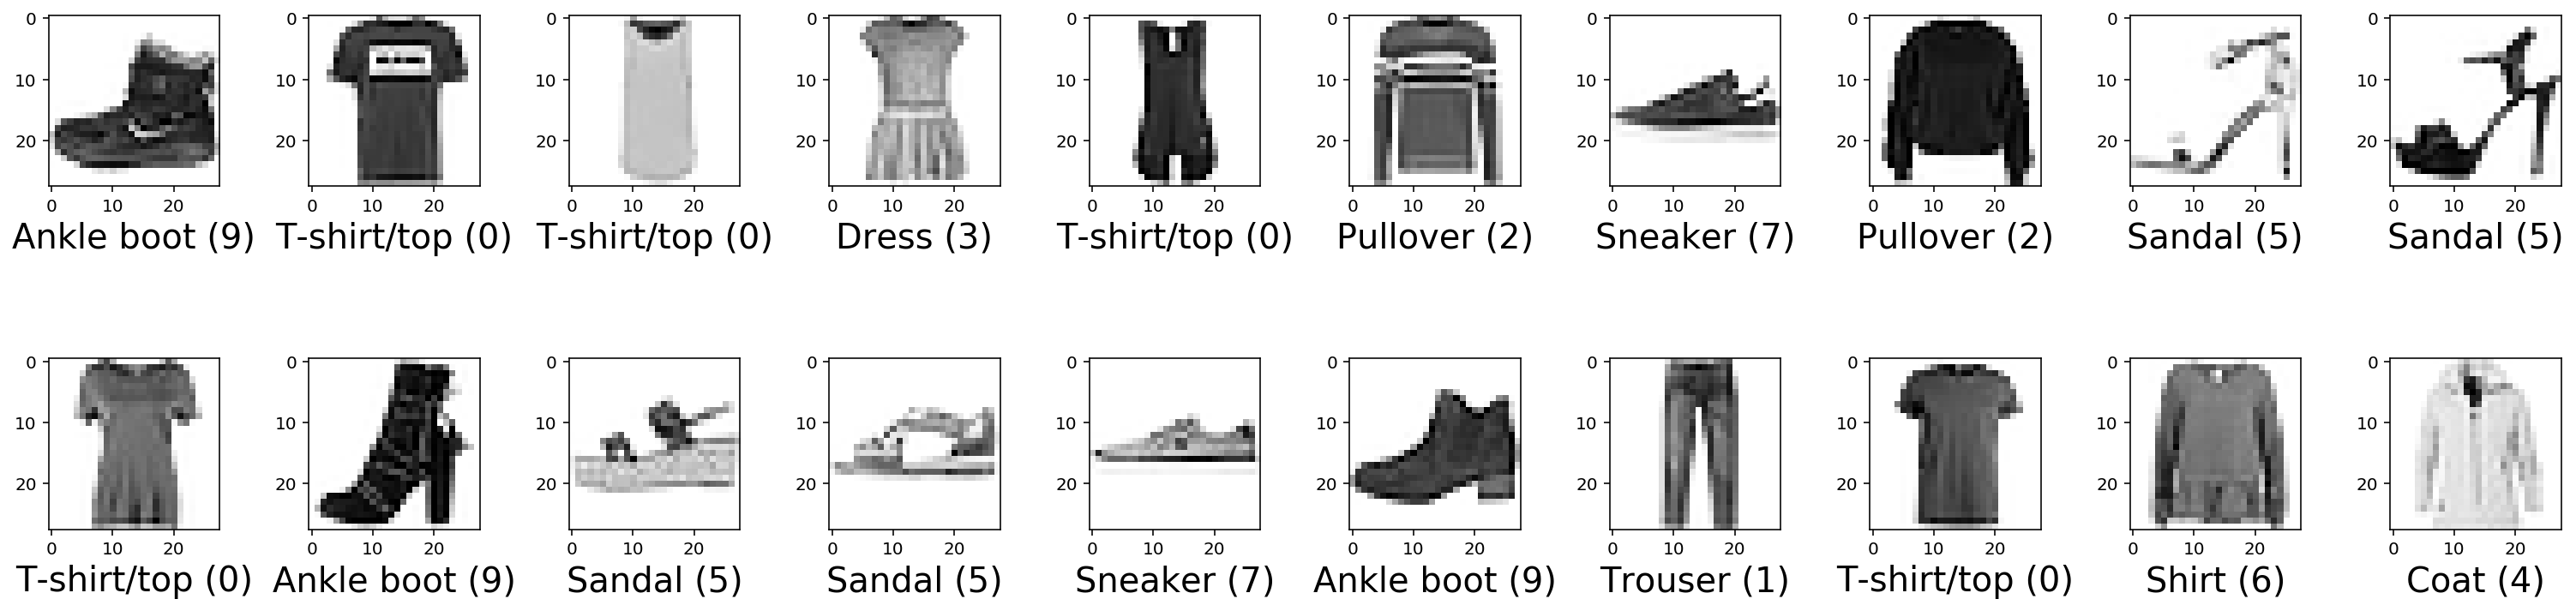

Label assignment:  {0: 'T-shirt/top', 1: 'Trouser', 2: 'Pullover', 3: 'Dress', 4: 'Coat', 5: 'Sandal', 6: 'Shirt', 7: 'Sneaker', 8: 'Bag', 9: 'Ankle boot'}


In [4]:
fashion_train = np.load('data/mnist_fashion_train.npz')
fashion_test = np.load('data/mnist_fashion_test.npz')

label_names = {0:'T-shirt/top',1:'Trouser',2:'Pullover',3:'Dress',4:'Coat',5:'Sandal',6:'Shirt',7:'Sneaker',8:'Bag', 9:'Ankle boot'}

# Plots a list of images and corresponding labels
def plot_items(images,labels=None,gt_labels=None):
    num_images = len(images)
    images_per_row = 10
    num_rows = np.ceil(num_images / images_per_row)
    for i,image in enumerate(images):
        # create subfigure for image
        ax = plt.subplot(num_rows,images_per_row,i+1)
        plt.imshow(image, cmap='Greys', interpolation='None')
        # show label name
        if labels is not None:
            plt.xlabel("{} ({})".format(label_names[labels[i]], labels[i]),fontsize=20)
        # indicate correct or false prediction with a green or red border
        if gt_labels is not None:
            rect = patches.Rectangle((0,0),27,27,linewidth=3,edgecolor='g' if labels[i]==gt_labels[i] else 'r',facecolor='none')
            ax.add_patch(rect)

    plt.tight_layout() # remove some unnecessary space between images
    plt.show()

plot_items(fashion_train['images'][:20], fashion_train['labels'])
print('Label assignment: ',label_names)

#### What can we observe in the above output? 

Images are grayscale, have 28x28 pixels, are randomly ordered and are assigned to ten classes named

0. Tshirt/top
1. Trouser
2. Pullover
3. Dress
4. Coat
5. Sandal
6. Shirt
7. Sneaker
8. Bag
9. Ankle boot

You may be wondering why the images have such low resolution. This is an intentional choice on our part to make the classification problem tractable with relatively simple neural networks. For higher-resolution images convolutional neural networks with a very deep architecture would be required, which is beyond the scope of this homework exercise. Yet, the principles we develop in this exercise generalize to such models and higher resolutions. 

In a first step, we will inspect the statistics of the dataset and prepare it for machine learning.

**TODO:** First, compute and plot the mean image across the fashion training dataset. Note that the mean images have the same dimension as a single image and ``fashion_train['images']`` has shape ``(50000, 28, 28)``. Think about the dimension along which you apply ``np.mean``. Throughout this whole exercise, type your solution in the provided field right below the task discription.

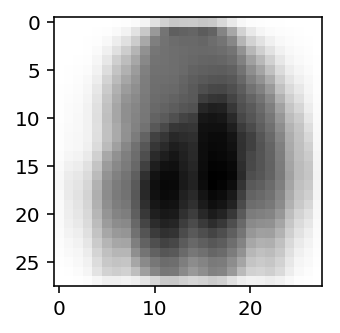

In [5]:
# solution
# Get the mean of each pixel -- apply np.mean along the 0 axis, to get a 28 x 28 final shape for the mean image
mean_image = fashion_train['images'].mean(0)
plot_items([mean_image])

**TODO:** That mean image is not very expressive. Compute  class-specific means for all classes: for instance, the mean pullover image would only consider images with ``fashion_train['labels']==8``.
Plot the class-specific mean images together with their labels using the function ``plot_items`` provided above. Inspect the first code block of this exercise to learn about the arguments of ``plot_items``.

T-shirt/top


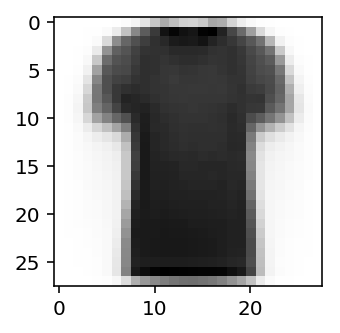

Trouser


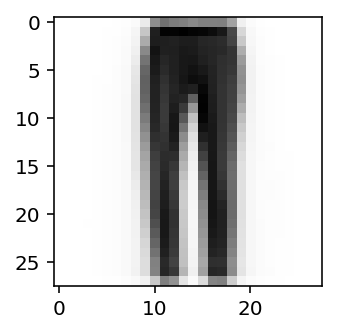

Pullover


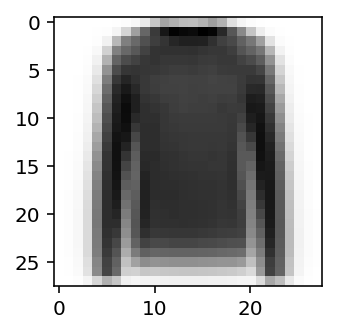

Dress


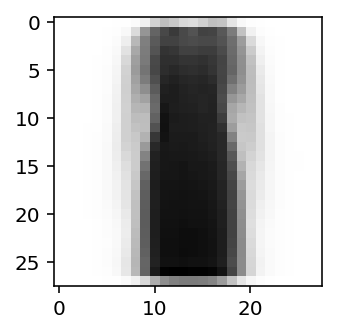

Coat


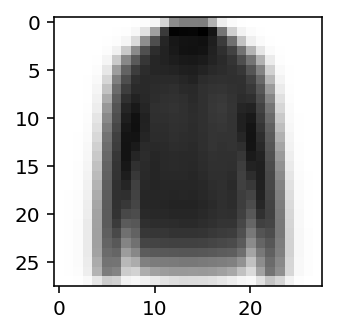

Sandal


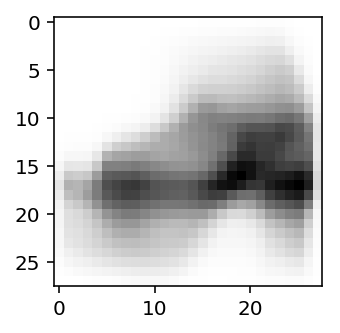

Shirt


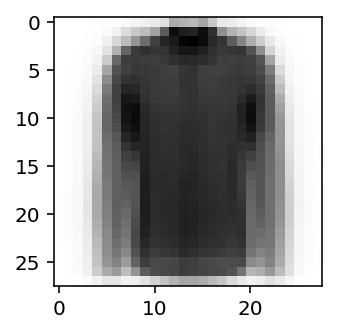

Sneaker


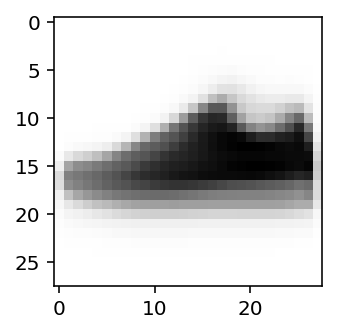

Bag


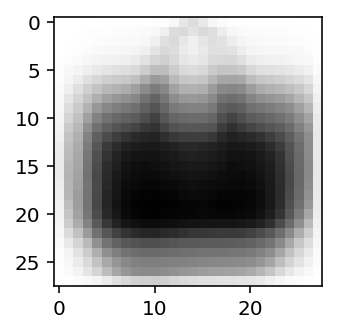

Ankle boot


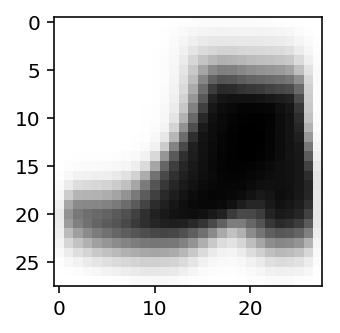

In [6]:
# solution

# create dict of labels and mean for the class
class_mean = {}

for i in range(10):
    
    # filter only images with label = i
    filtered_fashion = (fashion_train['labels'] == i)
    mean_filtered = fashion_train['images'][filtered_fashion].mean(0)
    
    # store mean for class i in dictionary
    class_mean[i] = mean_filtered
    
    # print the label name and corresponding plot
    print(label_names[i])
    plot_items([mean_filtered])

That looks more interesting. Observe the agreement of the mean shapes with their semantic labels. This is partly due to the fact that all objects are oriented upright and are centered. Such centering is a common preprocessing step and eases the learning task. The mean shoe looks quite different from the mean top, hence these will be easy to distinguish. However, determining the right shoe class (sandal, sneaker, boot) and top class (top, pullover, coat, shirt) will be more difficult.

Neural networks are composed of interchangeable building blocks, including the network architecture, activation function, and initial weights. Choosing the right components for a given problem can be hard. By normalizing the input and output, these choices are less sensitive to the specific task. We will follow the common practice and normalize the standard deviation of all input variables to one and the mean to zero. This process is called **whitening transformation**.

**TODO:** To be able to normalize the fashion dataset, compute the mean pixel value and its standard deviation of the training set. Note that opposed to the previous task we are not interested in the mean image, but the mean value across all pixels (i.e. a scalar value).

In [7]:
# solution
fashion_mean = fashion_train['images'].mean()
fashion_std = fashion_train['images'].std()
print('fashion_mean = ',fashion_mean,'fashion_std = ',fashion_std)

fashion_mean =  72.8022218622 fashion_std =  89.960030211


We use these values in the following to normalize the training and test images by subtracting the mean and dividing by the standard deviation. Furthermore, we limit the number of examples to 10k by default, to reduce execution time.

In [8]:
def fashion_prepare_regression(dataset, max_iterations=10000):
    return {'images': (dataset['images'][:max_iterations] - fashion_mean) / fashion_std,
            'labels':  dataset['labels'][:max_iterations]}

fashion_train_regression = fashion_prepare_regression(fashion_train)
fashion_test_regression  = fashion_prepare_regression(fashion_test)

Having defined our training and test sets using proper data normalization, we are ready to implement and deploy deep learning.

## 2 Constructing a fully connected artificial neural network

Our goal is to construct a **fully connected network** consisting of $n$ layers. Each layer consists of several artificial neurons which apply non-linear activation functions on the output of the preceding layer, as sketched in the following graph. This overal approach is inspired by the behavior of real neurons in biological organisms, albeit with significant simplifications.

<br><img width="300" src="images/NeuralNetwork_nodeRep_simple_cut.png"><br>

Networks become more powerful the more neurons are used. Each additional neuron als increases the number of parameters that must be optimized, and larger networks easily have on the order of thousands or even millions of parameters. In such cases, performance becomes an important concern. Luckily, nodes within a layer can be executed in parallel. Pay attention to use numpy vector and array operations as often as possible to avoid inefficient for-loop constructs.To gain full points, vectorized solutions are mandatory. 

### 2.1 Activation Units (10 points)

We now turn to constructing the neural network; from the activation function of single neurons, over layers, to the composition of the complete network. Activation functions are simple but important. Without them every neural network (no matter how deep) would collapse to a simple linear function, which is not powerful. Instead, we want to be able to use the neural network to approximate a complex non-linear function that will allow us to accomplish our goal of classifying clothing articles.

**TODO:** Define a function ``relu(x)`` that takes a vector ``X`` as input and returns the element-wise RELU activation. Make use of ``np.maximum`` in its implementation. Also define the function ``identity(x)`` that maps ``x`` to ``x``.

For comparison, we already provide the sigmoid activation function.

In [9]:
# solution
def relu(x):
    return np.maximum(0, x)

def identity(x):
    return x

def sigmoid(x):
    return scipy.special.expit(x)
    # a numerically stable implementation of sigmoid(x) = 1.0 / (1.0 + math.exp(-x))

**Verify:** ``relu([-1,0,1]) == [0,0,1]`` and ``identity([-1,0,1]) == [-1,0,1]``

In [10]:
assert np.all([
    relu(np.array([-1,0,1])) == np.array([0,0,1]), 
    identity(np.array([-1,0,1])) == np.array([-1,0,1])
])

**TODO:** To gain a feeling for the behaviour of the different activation functions, plot ``relu(x)``, ``identity(x)`` and ``sigmoid(x)`` for the range ``x`` $\in [-5,5]$ using ``plt``. Constrain the output range to ``(-1, 1)`` using ``plt.ylim``.

**Hint:** If you plot all three functions on the same plot, consider displaying a legend using the `label` argument of `plt.plot` and calling `plt.legend()`.
If you see plots that are overlapping, try executing the Prelude cell and this plot a second time.

(-1, 1)

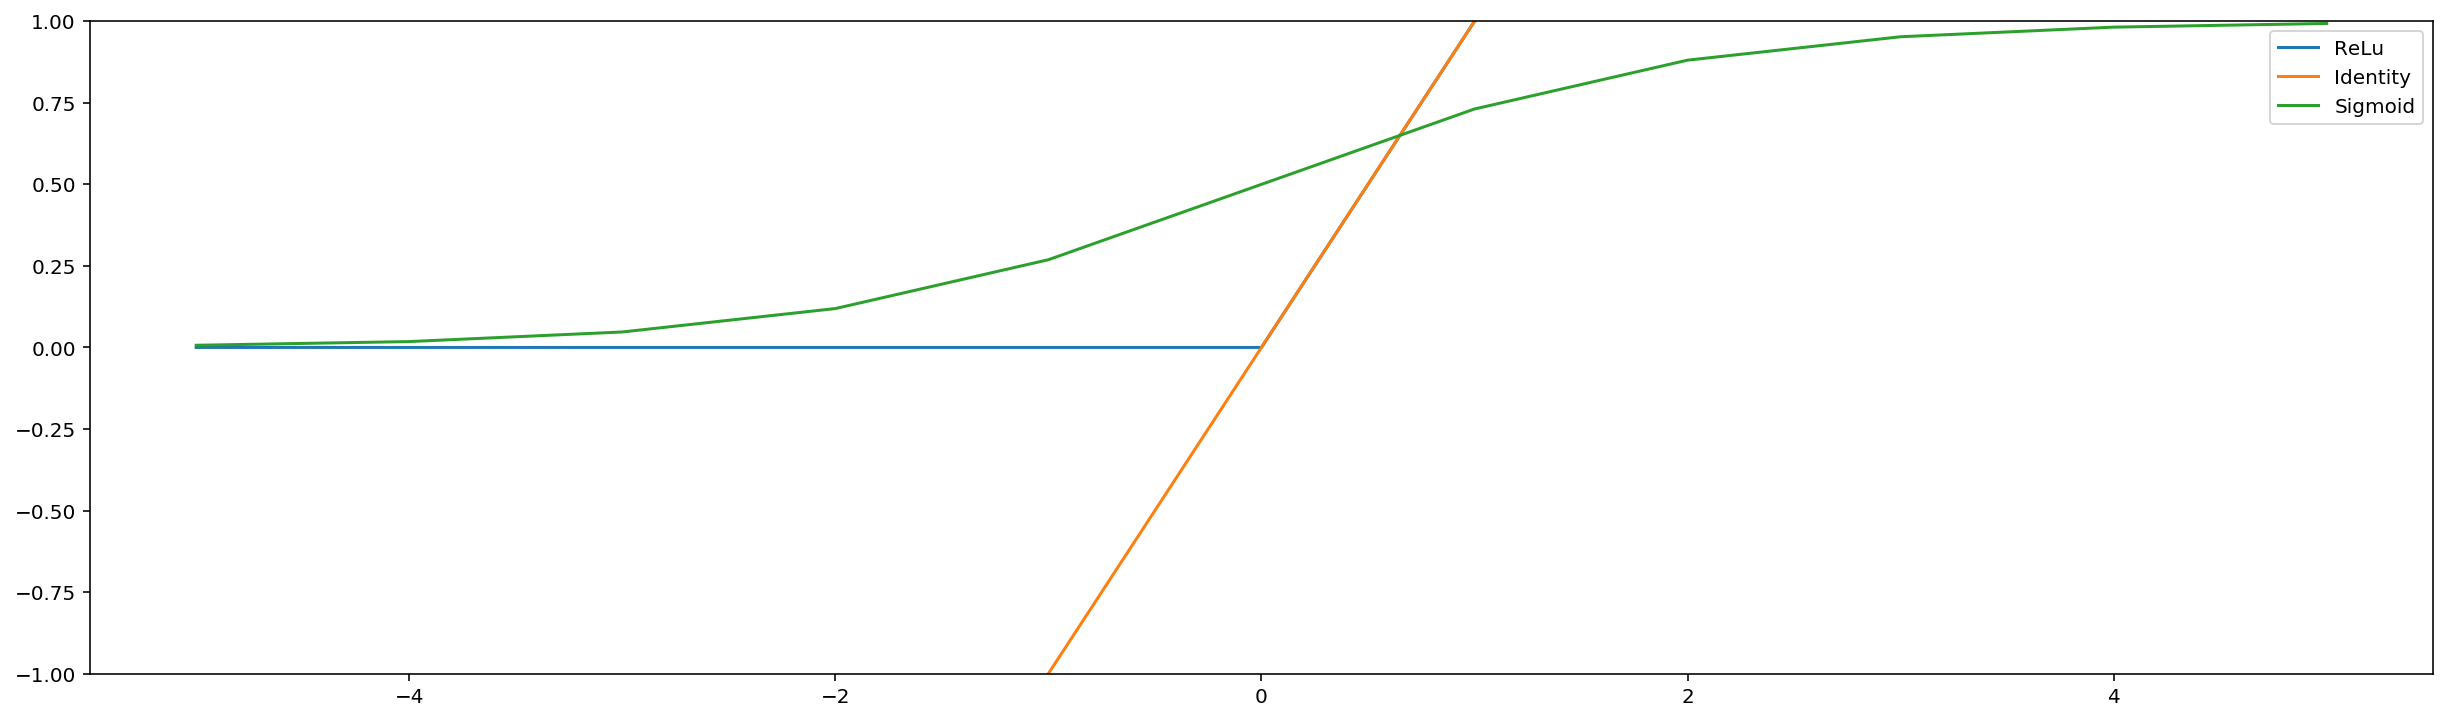

In [11]:
# solution

x = range(-5, 6)

plt.plot(x, relu(x), label='ReLu')
plt.plot(x, identity(x), label='Identity')
plt.plot(x, sigmoid(x), label='Sigmoid')
plt.legend()

plt.ylim(-1,1)

### 2.2 A single neuron (10 points)

In this task, we implement the most common artificial neuron representation. It computes the dot product of the input vector $\vx$ with a weight vector $\vw$ and applies the non-linear activation function $h$, as sketched below.

<img width="200" src="images/NeuralNetwork_single_neuron.png">

**TODO:** Implement the transformation of a single neuron ``neuron(x,w,b,h)``, where ``x`` and ``w`` are numpy vectors, ``b`` is a scalar bias, and ``h`` is a function, e.g. ``h=relu``.

In [12]:
# solution
def neuron(x, w, b, h):
    return h(x@w + b)

**Validate:** Does your function pass the following test with $\texttt{h=relu}$ activation functions? Vectorized output is correct, e.g., [6].

In [13]:
x = np.array([-1, 0, 1])
w = np.array([1, 2, 3])
assert np.all([
    neuron(x,   w, b=4, h=relu) == 6,
    neuron(x,   w, b=5, h=relu) == 7,
    neuron(x+1, w, b=5, h=relu) == 13,
])

### 2.3 Network definition (15 points)

The goal is to construct a fully connected neural network function nn($\vx, \mW^{(1)}, \mW^{(2)}, \vb^{(1)}, \vb^{(2)}, h$) that maps input $\vx \in \R^{m_0}$ to prediction $\vy \in \R^{m_2}$ through one hidden layer of width $m_1$ and activation function $h$, as sketched below.

<img width="300" src="images/NeuralNetwork_nodeRep.png">

Representing each neuron separately is complex and computationally inefficient. It is more practical to group neurons into layers and to represent each layer as vectorized function. The following sketch shows the simplification.

<img width="300" src="images/NeuralNetwork_layerRep.png">

The output $\va^{(i)}$ of layer $i$ is a vector of length $m_{i}$, the list of all outputs of individual neurons in that layer.
The output $\va^{(i-1)}$ of layer $i-1$ is the input to layer $i$.
Each neuron of layer $i$ takes the same input values, although it will generally apply different weights and bias terms.
The weighting for each of the $m_i$ neurons can thus be expressed as a matrix multiplication $\mW^{(i)} \va^{(i-1)}$, where $\mW^{(i)}$ has shape $[m_n, m_{n-1}]$. Multiple layers can be stacked to build a deep neural network.

**TODO:** Make yourself familiar with the layer dimensions. First, create a numpy weight matrix ``W1`` for a layer with 3 input and 4 outputs, and a second weight matrix ``W2`` for a layer with 4 inputs and 2 outputs. Second, define corresponding bias vectors ``b1`` and ``b2``. Fill all elements with the value ``1``.

In [14]:
# solution
# Shape of weight = [len(output), len(input)]
W1 = np.ones((4,3))
W2 = np.ones((2,4))
# Shape of bias = [len(output), 1]
b1 = np.ones(4)
b2 = np.ones(2)

**Validate:** Verify that the matrix shapes are correct. The output of the tested matrix multiplication should be five and the biases sum to seven.

In [15]:
assert np.all(W2 @ W1 == np.array([[ 4.,  4.,  4.],[ 4.,  4.,  4.]])) and sum(b1)+sum(b2) == 6

To build a complete network, we must chain the matrix product, constant offset and non-linear operation together. 

**TODO:** First, implement ``linear(``$\vx$, $\mW$, $\vb\!\!$ ``)`` that computes the affine part of the neural layer. We follow the common practice and call it a linear layer. Its name can be justified in that affine transformations are linear in homogeneous coordinates. This works analogously to the single neuron implementation but now operates on a weight matrix instead of a weight vector and a bias vector instead of a bias scalar.

**Hint:** Make sure that you use NumPy operations and use the ``@`` operator for matrix multiplication.

In [16]:
# solution
def linear(x, W, b):
    return W@x + b

**Verify:** Do you pass the following tests?

In [17]:
assert np.all(linear(np.array([-1,0,1.5]), W1, b1)   == np.array([ 1.5,  1.5,  1.5,  1.5])) 
assert np.all(linear(np.array([-1,0,1,1.5]), W2, b2) == np.array([ 2.5,  2.5]))

**TODO:** Complete the following implementation of a two-layer neural network ``nn(``$\vx,\mW^{(1)},\mW^{(2)},\vb^{(1)},\vb^{(2)},h\!\!$ ``)``. Given the input $\vx$, it shall compute the complete forward pass of the network. Besides the input, it takes the weight matrixes, corresponding biases, and non-linear activation function. Use the previously used ``linear(x, W)`` function and apply ``h(x)`` only once after the first layer; not after the output layer to permit arbitrary output values. The previously shown network graphic provides a good reference.

**Note:** ``**kwargs`` is used here only to ignore additional arguments and comes in use later.

In [18]:
# solution
def nn(x, W1, W2, b1, b2, h, **kwargs):
    layer_1 = linear(x, W1, b1)
    activated_layer_1 = h(layer_1)
    return W2@activated_layer_1 + b2

**Verify:** The following code tests a network architecture with the previously defined weights ``[W1, W2]``, biases ``[b1, b2]`` and relu activation function (``h=relu``) on different inputs. Do you pass the test?

In [19]:
assert np.all(nn(np.array([-10, 0, -1]), W1, W2, b1, b2, relu) == np.array([  1.,   1.]))
assert np.all(nn(np.array([0  , 0, 0]),  W1, W2, b1, b2, relu) == np.array([  5.,   5.]))
assert np.all(nn(np.array([-1 , 2, 1]),  W1, W2, b1, b2, relu) == np.array([ 13.,  13.]))

Congratulations. You've just built all the code that is needed to evaluate a neural network! However, an untrained network without sensible weights is not particularly useful.

## 3 Training a NN

We will use the simple yet efficient iterative gradient descent optimization to find the network parameters (Section 3.5).
This requires finding a good starting point (Section 3.1 Network initialization), as well as the objective function with respect to the parameters (Section 3.4 Backpropagation).

Gradients in turn require the ability to compute Jacobians of the intermediate steps (Section 3.2 Layer-wise Jacobian matrices) and gradients of the loss functions (Section 3.3 Objective function).

### 3.1 Network initialization (5 points)

Note that random initialization of the network weights is crucial. For instance, setting all weights to a constant value would create the same function and gradient at each node of a layer, forcing a whole layer to behave like a single neuron under gradient-based optimization.
Assigning all weights from the uniform distribution between zero and one is also problematic. The mean and variance of the output would grow with the number of hidden layers and neurons.

**TODO:** Implement the function ``init_weights(rows,columns)`` that takes the number of rows and columns as input and returns a matrix ``W`` of that shape. The elements of ``W``  shall be random, drawn from the uniform distribution across the range $[-\sqrt{\frac{3}{m}}, \sqrt{\frac{3}{m}}]$, where $m$ is the number of columns. This choice addresses the problems mentioned above. Use NumPy's random number generator.

*Note*: NumPy's random number generator is deterministically initialized using ``np.random.seed`` so that you will always get the same initialization. Keep it as the first line of your function.

In [20]:
# solution (10 pts: 3 for correct range, 2 for using .uniform or .rand without for loop)
def init_weights(rows, columns):
    np.random.seed(rows*columns)
    bound = np.sqrt(3/columns)
    W = np.random.uniform(low = -bound, high = bound, size = (rows, columns))
    return W

**Verify:** Is your weight initialization correct? The following code computes the mean and standard deviation of a wide network with a single hidden layer. The mean should be roughly zero and std roughly one. In my output, they match up to one digit but mind that it is a random number.

In [21]:
random_output = nn(x=np.random.uniform(-np.sqrt(3), np.sqrt(3), size=(1000)), 
                   W1=init_weights(1000, 1000),
                   W2=init_weights(1000, 1000),
                   b1=np.zeros([1000]),
                   b2=np.zeros([1000]),
                   h=identity)

print("mean = {}, std = {}".format(np.mean(random_output), np.std(random_output)))

assert np.allclose([np.mean(random_output), np.std(random_output)], [0,1], atol=1e-01)

mean = -0.016402974595571326, std = 1.0292219025702214


## Hacker Points (optional, 5 points)

The factor $\sqrt{\frac{3}{m}}$ used for initialization seems arbitrary. Why does that specific value preserve a mean of zero and standard deviation of 1? 

**TODO:** Inspect the propagation of variances through the network. Let $\var(\vw_1 \vx_1 + \dots + \vw_n \vx_n)$ be the variance of the output of a neuron with identity activation and bias equal to 0, where $\vw$ is the weight vector of the neuron and $\vx$ the input vector. First, derive the variance of $\vw_i$ that is necessary to make $\var(\vw_1 \vx_1, \dots, \vw_n \vx_n)$ equal to one, assuming that all $\vx_i$ have variance one. Second, infer why $\vw_i$ should be initialized uniformly at random between $-\sqrt{\frac{3}{m}}$ and $\sqrt{\frac{3}{m}}$.

**Hint:** You can use $\var(x+y) = \var(x)+\var(y)$, $\var(x y) = \var(x) \var(y)$ (if x,y are independent and have zero mean, which can be assumed here), and $\var(\text{uniform}(-a,a)) = \frac{1}{3} a^2$.

<div class="alert alert-block alert-info">
Write your Hacker Point solution in this Markdown cell; using latex for equations and plain text for explaining each step and your final conclusion.
</div>

$\var\left(\sum \vx_i \vw_i \right) = \text{TODO}$

### 3.2 Layer-wise Jacobian matrices (15 points)

Our deep neural network has universal approximation capabilities. It remains to find a good set of parameters to unleash its computational power. We will use (stochastic-) gradient descent and the backpropagation algorithm to compute gradients.

To apply the backpropagation algorithm we need to know the derivative of our objective. Since our NN-functions are multivariate it means that we need to derive the Jacobian matrices of all intermediate steps. Recall that the Jacobian matrix of $f$ with respect to $\vx$ is defined as

$$
{\displaystyle J^f_\vx
=\frac{\partial f}{\partial \vx}
={\begin{bmatrix}{\dfrac {\partial f_{1}}{\partial \vx_{1}}}&\cdots &{\dfrac {\partial f_{1}}{\partial \vx_{n}}}\\\vdots &\ddots &\vdots \\{\dfrac {\partial f_{m}}{\partial \vx_{1}}}&\cdots &{\dfrac {\partial f_{m}}{\partial \vx_{n}}}\end{bmatrix}}},
$$

where $f_i$ is the i'th output of function $f$, $\vx_j$ is the j'th element of the input $\vx$, and $\dfrac {\partial f_{i}}{\partial \vx_{j}}$ the partial derivative of $f_i$ with respect to $\vx_j$. For a function $h$ that performs element wise operations the Jacobian is of diagonal form:

<img width="200" src="images/Jacobian_h_x.png">

**TODO:** Define functions that compute the Jacobian matrices $\mJ^{\relu}_\vx$ and 
$\mJ^{\identity}_\vx$of the vectorized relu and identity functions, respectively. We provide the Jacobian of the sigmoid function as a hint.

In [22]:
# solution
def d_relu_d_x(x):
    # since relu function is max(0, x):
    # if x <= 0 -> y = 0 -> derivative of 0 is 0
    # if x > 0 -> y = x -> derivative of x is 1
    rx = np.copy(x)
    rx[rx<=0] = 0
    rx[rx>0] = 1
    return np.diag(rx)

def d_identity_d_x(x):
    ix = np.array(np.ones(len(x)))
    return np.diag(ix)

def d_sigmoid_d_x(x): 
    # sigmoid(x) := e^{x} / (e^{x}+1)
    # diff(e^x) = e^x
    # d_sigmoid_d_x = (e^x * (e^{x}+1) - e^x * e^x) / {(e^{x}+1)*(e^{x}+1)}
    #               = e^x / (e^{x}+1) * ((e^{x}+1) - e^x) / (e^{x}+1)
    #               = sigmoid(x)*(1-sigmoid(x))
    sx = sigmoid(x)
    return np.diag(sx * (1.0 - sx))

**Verify:** Test your implementations on the vector ``x = [-1,0,2]``. Is the output a vector or a matrix, of square or non-square shape?

In [23]:
test_x = np.array([-1,0,2])
print("d_relu_d_x =\n{}".format(d_relu_d_x(test_x)))
print("d_identity_d_x =\n{}".format(d_identity_d_x(test_x)))
print("d_sigmoid_d_x =\n{}".format(d_sigmoid_d_x(test_x)))

d_relu_d_x =
[[0 0 0]
 [0 0 0]
 [0 0 1]]
d_identity_d_x =
[[ 1.  0.  0.]
 [ 0.  1.  0.]
 [ 0.  0.  1.]]
d_sigmoid_d_x =
[[ 0.19661193  0.          0.        ]
 [ 0.          0.25        0.        ]
 [ 0.          0.          0.10499359]]


The output is always a diagonal square matrix.

The Jacobian matrix of the $\linear$ function is more intricate since it has three arguments and must be differentiated with respect to all of them. As discussed in the lecture, the shape of $\mJ^{\linear}_\vx$ is dense. The following image sketches the Jacobian matrix of ``linear(``$\mathbf{x},\mW^{(2)},\vb^{(2)}\!\!$ ``) `` with respect to $\mathbf{x}$:

<img width="300" src="images/J_linear_x.png">

**TODO:** Define $\mJ^{\linear}_\vx$, i.e. the Jacobian of ``linear(``$\mathbf{x},\mW, \vb\!\!$ ``) `` with respect to ``x``.

In [24]:
# solution
def d_linear_d_x(x, W, b):
    return W

**Verify:** Are your dimensions correct for the application on $\mW = [[1,-2,-3],[-5,-6,7]]$? The right output is $\texttt{d_linear_d_x = [[1 -2 -3],[-5 -6 7]]}$.

In [25]:
W = np.array([[1,-2,-3],[-5,-6,7]])
b = np.array([-1,0,1])
assert np.all( d_linear_d_x(None,W,b) == np.array([[1,-2,-3],[-5,-6,7]]) )

**TODO:** Define $\mJ^{\linear}_\vb$, i.e. the Jacobian of ``linear(``$\mathbf{x},\mW, \vb\!\!$ ``) `` with respect to ``b``.

In [26]:
# solution
def d_linear_d_b(x, W, b):
    deriv_b = np.ones(W.shape[1])
    diag = np.diag(deriv_b)
    return diag

**Verify:** Are your dimensions correct this time? The right output is tested below.

In [27]:
assert np.sum(d_linear_d_b(None,W,b)) == 3  and d_linear_d_b(None,W,b).size==9

How can one possibly compute the Jacobian of multidimensional function with respect to a matrix $\mW$? Is it a tensor?
To simplify the matter we reshape $\mW$ into a vector (also called **flattening**) and construct the Jacobian matrix $\mJ^{\linear}_\mW(\vx,\mW)$ as before. We compute the derivative of the outputs of $\linear$ with respect to all elements of $\mW$.  

We provide you with the implementation for this step. Since the $i$th output is defined by row $i$ of ``W`` and is independent of rows $j \neq i$ the Jacobian matrix has diagonal structure. Since each row of $\mW$ is multiplied by $\vx$ (ordinary matrix multiplication of $\mW \vx$), $\vx$ is replicated in the diagonal, e.g. for $\mW^{(1)}$:
<img width="400" src="images/J_linear_W.png">
This diagonal structure can be constructed efficiently using a <a href="https://en.wikipedia.org/wiki/Kronecker_product">Kronecker product</a>:

In [28]:
def d_linear_d_W(x, W, b):
    num_outputs = W.shape[0]
    return np.kron(np.eye(num_outputs), x)

### 3.3 Objective function (10 points)

The last missing ingredient is to define and differentiate the objective function so that it can be minimized using gradient descent. Our goal is to predict the class of garment shown in the input image. We would like to penalize if the network predicts wrong labels. We chose the objective function $E_i = \|nn(\vx_i,[\mW^{(1)},\mW^{(2)},\vb^{(1)},\vb^{(2)}]) - \vy_i\|^2$.

Its goal is to estimate the difference between prediction $nn(\vx_i,[\mW^{(1)},\mW^{(2)},\dots])$ and class label $\vy_i$, for all input-label pairs $(\vx_i,\vy_i)$ in the training set. Note, that we use the $l_2$ norm as a loss (squared loss). It is efficient to compute and everywhere differentiable. 
For instance, the network can be trained to output the bag label 8 when executed on a bag image by penalizing every other prediction quadratically:

<img width="500" src="images/ObjectiveFunction.png">

Later, we will use a network that outputs multiple labels, i.e. outputs a vector, which requires the norm notation $\| \cdot \|$ above. It simply means that we take sum of the squared differences of all output and label elements, $l_2(\vx,\vy) = \|\vx - \vy\|^2 = \sum_j (\vx[j] - \vy[j])^2$, where $[j]$ acesses the j'th element. 

**TODO:** Implement the $l_2$ loss function ``l2(x,y)``. It shall take vectorized input and compute the sum over the squared differences of the prediction and the labels (element-wise).

**TODO:** Second, derive and implement the function ``d_l2_d_x(x,y)`` that computes the Jacobian $J_\vx^{l_2}(\vx,\vy) = \frac{\partial l_2}{\partial \vx}(\vx,\vy)$. Recall that the elements of $\frac{\partial l_2}{\partial \vx}(\vx,\vy)$ are the partial derivatives of ``l2(x,y)`` with respect to the individual elements of $\vx$.

**Hint:** The output of the loss is always a scalar, this implies that the Jacobian is a $1\times m_i$ matrix (row vector), where $m_i$ is the length of ``x``. It may be esier to first derive the scalar form (``x`` and ``y`` beeing np.arrays with a single element) and to subsequently extend it to handle vectorized input. We test both cases below.

In [29]:
# solution
def l2(x,y):
    diff = x - y
    return np.sum(diff@diff)

def d_l2_d_x(x,y):
    diff = x - y
    return 2*diff

**Verify:** Test that both, the scalar and the vectorized case, pass.

In [30]:
x = np.array([1])
y = np.array([2])
assert l2(x,y)==1 and d_l2_d_x(x,y)==np.array([[-2]])

x = np.array([-1,0,1])
y = np.array([1,1,2])
assert l2(x,y)==6 and np.all( d_l2_d_x(x,y)==np.array([[-4,-2,-2]]) )

### 3.4 Backpropagation

<div class="alert alert-block alert-info">
Note: Section 3.4 explains the backpropagation algorithm that is needed to obtain the optional hacker points below. (However, we recommend that you study this algorithm even if you don't plan to obtain the hacker points.)
</div>


Having derived gradients and Jacobians of all intermediate steps, it remains to chain them together. For a neural entwork with a single hidden layer and ReLU activation the forward pass computes

$$nn(\vx_i,\mW^{(1)},\mW^{(2)},\vb^{(1)},\vb^{(2)}) = \linear(\relu(\linear(\vx_i,\mW^{(1)},\vb^{(1)})),\mW^{(2)},\vb^{(2)}).$$

Hence, the objective function for example $i$ is

$$E_i = l_2\left( \linear(\relu(\linear(\vx_i,\mW^{(1)},\vb^{(1)})),\mW^{(2)},\vb^{(2)}) - \vy_i\right).$$

One can evaluate this expression with the following intermediate computations,

$\mathbf{x0} = \vx_i$<br>
$\mathbf{x1} = \linear(\mathbf{x0}, \mW^{(1)}, \vb^{(1)})$<br>
$\mathbf{x2} = \relu(\mathbf{x1})$<br>
$\mathbf{x3} = \linear(\mathbf{x2}, \mW^{(2)}, \vb^{(2)})$<br>
$E_i = l_2(\mathbf{x3},\vy_i)$.
 
We are interested in the gradient of the objective function with respects to the neural network weights $\mW^{(1)},\mW^{(2)},\vb^{(1)}$ and $\vb^{(2)}$. By the chain rule, the Gradient of $E_i$ with respect to $\mW^{(2)}$ is then

$$
\frac{\partial E_i}{\partial \mW^{(2)}} = 
\sum_{i} 
\mJ^{l_2}(\mathbf{x3}) \;\;
\mJ^{\linear}_{\mW}(\mathbf{x2},\mW^{(2)},\vb^{(2)})
,$$

using the previously defined intermediate computations. Similarly for $\mW^{(1)}$ we compute,

$$
\frac{\partial E}{\partial \mW^{(1)}} = 
\sum_{i} 
\mJ^{l_2}(\mathbf{x3}) \;\;
\mJ^{\linear}_{\mathbf{x}}(\mathbf{x2},\mW^{(2)},\vb^{(2)}) \;\;
\mJ^{\relu}(\mathbf{x1}) \;\;
\mJ^{\linear}_{\mW}(\mathbf{x0},\mW^{(1)},\vb^{(1)}).$$

These equations are a strict application of the chain rule [2] at the abstraction level of layers. The equation has the following structure.
<img width="600" src="images/J_E_W1.png">

To derive the gradient with respect to $\vb$, we simply exchange $\mJ^{\linear}_{\mW}$ with $\mJ^{\linear}_{\vb}$. Since the multiplication of subterms is associative there are several ways of implementing that computation. Such as starting from the left- or right-hand side of the expression. 
<br>[2] https://en.wikipedia.org/wiki/Chain_rule#Higher_dimensions

We will use the backpropagation algorithm, i.e. starting multiplication from the left-hand side. It is more efficient than forward propagation of gradients since intermediate results are vectors, not matrices, as shown in the sketch. We provide you with the following naive implementations for backpropagating the gradient $\frac{\partial E}{\partial \vx}$. 

In [31]:
# provided naive implementation
def backprop_identity_x(JE_x, x):
    return JE_x @ d_identity_d_x(x)

def backprop_relu_x(JE_x, x):
    return JE_x @ d_relu_d_x(x)

def backprop_linear_x(JE_x, x, W, b):
    return JE_x @ d_linear_d_x(x, W, b)

def backprop_linear_W(JE_x, x, W, b):
    return JE_x @ d_linear_d_W(x, W, b)

def backprop_linear_b(JE_x, x, W, b):
    return JE_x @ d_linear_d_b(x, W, b)

This strategy is correct and generally applicable, but
naive since it propagates $\frac{\partial E}{\partial \vx}$ through function $f$ by multiplying it with the Jacobian matrix $J^f$ without considering the structure of the Jacobian (zero entries). 
We provide a more efficient implementation for ``backprop_linear_W`` and ``backprop_linear_x``. Solve the following hacker task if you want to speed up the remaining propagations.

In [32]:
# fast implementation
def backprop_linear_W(JE_x, x, W_UNUSED, B_UNUSED):
    #return JE_x.T * x.reshape(1,-1)
    return JE_x.T.reshape(-1, 1) @ x.reshape(1,-1)

def backprop_linear_x(JE_x, x, W, b):
    return JE_x @ W

### Hacker points (optional, 5 points)

Our naive implementation explicitly creates Jacobian matrices in every backpropagation function. These matrices can be huge, e.g. $100\times1000$ for a layer with 1000 input and 100 output nodes.
 
**TODO:** The sparse structure of the apparent Jacobian matrices allow for a more efficient implementation. Reimplement the backpropagation functions ``backprop_identity_x``, ``backprop_linear_b``, and ``backprop_relu_x`` without explicitly computing an intermediate (Jakobian) matrix. Recap how the Jacobian matrices are constructed and find a way to express the naive matrix multiplication, e.g., with element-wise multiplications.

**Hint:** The backpropagation for $\mW^{(1)}$ is sketched in the following, which operations do you have to implement for the placeholders $(?)$?
<img width="800" src="images/E_backprop_W1_question.png">

**Verify:** Verify that your implementation gives the same result as our naive implementation.

In [33]:
# solution
def backprop_identity_x(JE_x, x):
    return JE_x @ d_identity_d_x(x) # TODO

def backprop_relu_x(JE_x, x):
    return JE_x @ d_relu_d_x(x)

def backprop_linear_b(JE_x, x, W, b):
    #return JE_x @ d_linear_d_b(x, W, b) # TODO
    return JE_x * np.ones(W.shape[1]).reshape(-1,1)

### 3.4.1 Backpropagation continued (0 points)

We provide the following implementation for the backpropagation algorithm. It chains the layer-wise functions together: A forward pass stores intermediate values, the l2 loss is differentiated, and the loss gradient is  propagated backwards iteratively.

In [34]:
def backprop_nn_W(x, label, W1, W2, b1, b2, h, back_h):
    # network forward pass, saving intermediate x values
    x1 = x
    x2 = linear(x1, W1, b1)
    x3 = h(x2)
    x4 = linear(x3, W2, b2)
    # loss backwards
    JE_x = d_l2_d_x(x4, label)
    # network backwards pass, using intermediate x values
    JE_W2 = backprop_linear_W(JE_x, x3, W2, b2)
    JE_b2 = backprop_linear_b(JE_x, x3, W2, b2)
    JE_x  = backprop_linear_x(JE_x, x3, W2, b2)
    JE_x  = back_h(JE_x, x2)
    JE_W1 = backprop_linear_W(JE_x, x1, W1, b1)
    JE_b1 = backprop_linear_b(JE_x, x1, W1, b1)
    return JE_W1, JE_W2, JE_b1, JE_b2

### 3.5 Stochastic gradient descent optimization (10 points)

<div class="alert alert-block alert-info">
Before you proceed, make sure that all previous cells have been executed in order and without throwing an error. To ensure proper execution, select this cell and click on "Cell -> Run All Above" in the jupiter notebook menu.</div>

We now implement the gradient descent method to solve the fashion item classification problem.
The optimization is initialized at a random parameter value (Section 3.1), which is subsequently refined iteratively. Each iteration consists of two steps. First, the objective function gradient is computet by backpropagation (Section 3.4) to choose the descent direction.
Second, the network parameters are updated by a step with constant length in the descent direction.
Since our training set might be huge we utilize stochastic gradient descent, we pick a single example $i$ and minimize $E_i = (nn(x_i,\theta) - \text{y}_i)^2$. Traditional gradient descent would compute the gradient with respect to all exaples on $E = \frac{1}{D}\sum^{D}_{i=1} E_i$, which is intractable for sets of thousands of examples. 

The following approach is **stochastic**, as the order of examples in our database is randomly shuffled, which generally improves convergence and robustness of the optimization.

**TODO:** We prepared a skeleton for the optimization algorithm. Implement the missing weight update step for a constant learning rate, i.e. the steplength is given by the function argument ``learning_rate``. The remaining function arguments are the dataset list and network architecture definition. We provide an example network definition ``parameters_regression`` below, it has 784 inputs, 50 hidden units, and 1 output. The ``**parameters`` notation is used to unpack the dictionary elements and to pass them as arguments to the function ``backprop_nn_W``.

**Hint:** You have to ``reshape`` the parameter update to have the same dimensions as the parameters, i.e. into a matrix for $\mW$ and vector for $\vb$.

In [35]:
# solution
parameters_regression = {'W1': init_weights(50, 784),
                         'W2': init_weights(1, 50),
                         'b1': np.zeros([50]),
                         'b2': np.zeros([1]),
                         'h': relu,
                         'back_h': backprop_relu_x}

def train(data_train, parameters, learning_rate):
    # iterate over all image-label examples in the dataset
    for i, label in enumerate(data_train['labels']):
        # get image and flatten it to 1D
        x = data_train['images'][i].ravel() 
        
        # backpropagate gradient, returns list of gradients with respect to all W matrices
        JE_W1, JE_W2, JE_b1, JE_b2 = backprop_nn_W(x, label, **parameters)

        # TODO update parameters W1,W2,b1,b2, here started for W1
        
        parameters['W1'] += -learning_rate * JE_W1
        parameters['W2'] += -learning_rate * JE_W2
        parameters['b1'] += (-learning_rate * JE_b1)[0]
        parameters['b2'] += (-learning_rate * JE_b2)[0]

        if i % 100 == 0: 
            print("\r" + "Finished training iteration {}, learning rate = {}".format(i,learning_rate),end="")
    print("")

## 4 Recognize fashion items from images

Through solving the previous exercises, you developed a complete machine learning toolchain: preparation of the dataset, definition of the neural network forward and backward pass, as well as the iterative optimization routine. Now we apply it to our problem of estimating the fashion type from the image.

In machine learning there are two classes of problems, classifying discrete labels or regressing a continuous value.
First, we directly try to regress the class label as a continuous value between 0 and 9. It is simpler to implement than classification.

### 4.1 Regression (5 points)

We provide functions to compute the percentage of correct predictions
(**``fashion_acuracy``**) and to display the prediction on a small subset with correct predictions indicated by a green box (**``fashion_evaluate``**). The function **``outputToLabel_regression``** rounds a continuous value to the next valid integer label, to cope with non-integer predictions of the network.

In [36]:
def outputToLabel_regression(x):
    # round the prediction to the next integer value, and clip to the range 0..9, 
    return int(np.round(np.clip(x,0,9)))

def fashion_acuracy(parameters, data_test, outputToLabel):
    # compare prediction and label, only count correct matches
    accuracy = 100*np.mean([outputToLabel(nn(img.ravel(), **parameters)) == outputToLabel(output_gt) 
                        for img, output_gt in zip(data_test['images'], data_test['labels'])])
    return accuracy

def fashion_evaluate(parameters, data_test, outputToLabel):
    # construct for each example a tripel (image, prediction, label) and feed their elements to plot_items as separate lists
    image_prediction_label = [(img, outputToLabel(nn(img.ravel(), **parameters)), outputToLabel(output_gt)) 
                              for img, output_gt in zip(data_test['images'][:20], data_test['labels'][:20]) ]
    plot_items(*np.array(image_prediction_label).T.tolist()) 

**TODO:** Execute the following training code. It runs three times through the training data (1 cycle = 1 epoch). Note that it can take a minute since the input is high-dimensional. 

Finished training iteration 9900, learning rate = 0.001
Done epoch 0, accuracy = 39.57%
Finished training iteration 9900, learning rate = 0.001
Done epoch 1, accuracy = 38.67%
Finished training iteration 9900, learning rate = 0.001
Done epoch 2, accuracy = 41.92%


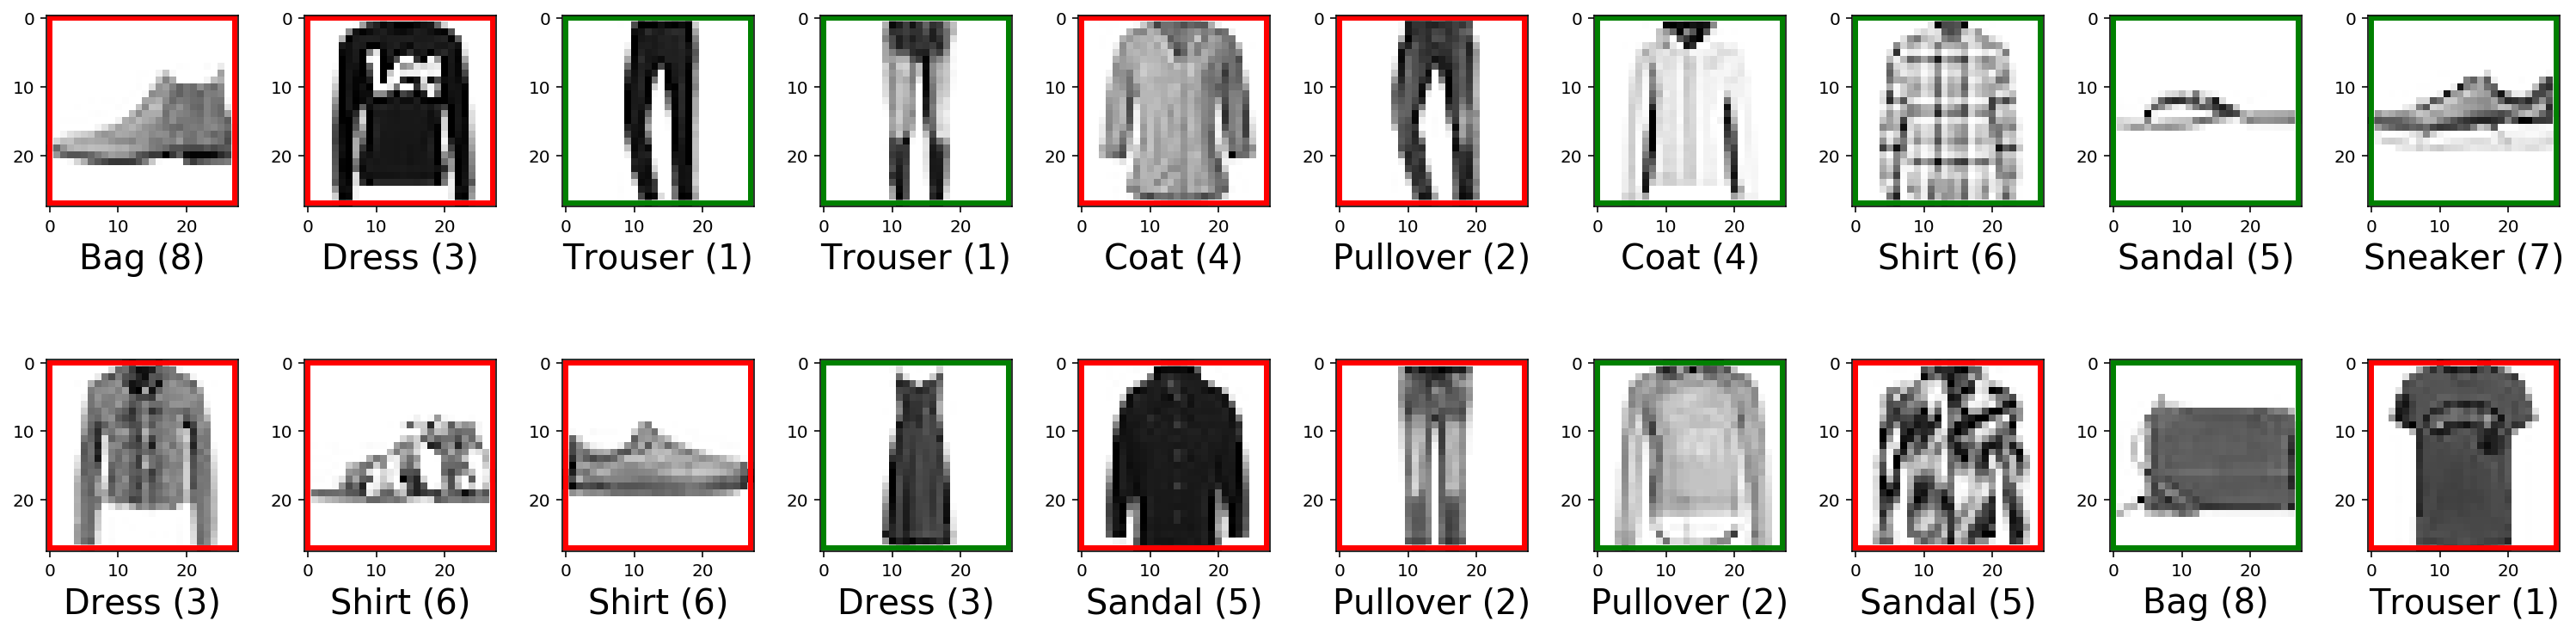

In [37]:
# optimization
num_epochs = 3
learning_rate = 0.001

# function to train on a provided dataset and network architecture defined by the parameters argument
def train_and_evaluate(parameters, num_epochs, learning_rate, 
                       data_train, data_test,
                       outputToLabel=outputToLabel_regression):
    # start each time from the same random initialization
    parameters = {k : v.copy() if type(v)== np.ndarray else v for k,v in parameters.items()}
    # loop over training data 
    accuracy = []
    for epoch in range(num_epochs):
        # train the network on all examples
        train(data_train, parameters, learning_rate=learning_rate)
        # compute the prediction accuracy in percent
        accuracy.append(fashion_acuracy(parameters, data_test, outputToLabel))
        print("Done epoch {}, accuracy = {}%".format(epoch, accuracy[-1]))
    fashion_evaluate(parameters, data_test, outputToLabel)
    return accuracy

# execute the training on parameters_regression
accuracy_reg_shallow = train_and_evaluate(parameters_regression, num_epochs, learning_rate,
                                  fashion_train_regression, fashion_test_regression)

Well, after three epochs of training the correct label is predicted in about $40\%$ of the cases. It is better than random ($10\%$ average accuracy) but not very useful. 

**TODO:** Is our first implementation better than linear regression? Define a network ``parameters_linear`` by replacing the relu non-linearities and train it on the fashion dataset. Note, you don't have to change any of the previous functions. Just define a new parameter dictionary, similar to ``parameters_regression``, and call ``train_and_evaluate`` on it.

Finished training iteration 9900, learning rate = 0.001
Done epoch 0, accuracy = 25.259999999999998%
Finished training iteration 9900, learning rate = 0.001
Done epoch 1, accuracy = 25.979999999999997%
Finished training iteration 9900, learning rate = 0.001
Done epoch 2, accuracy = 25.22%


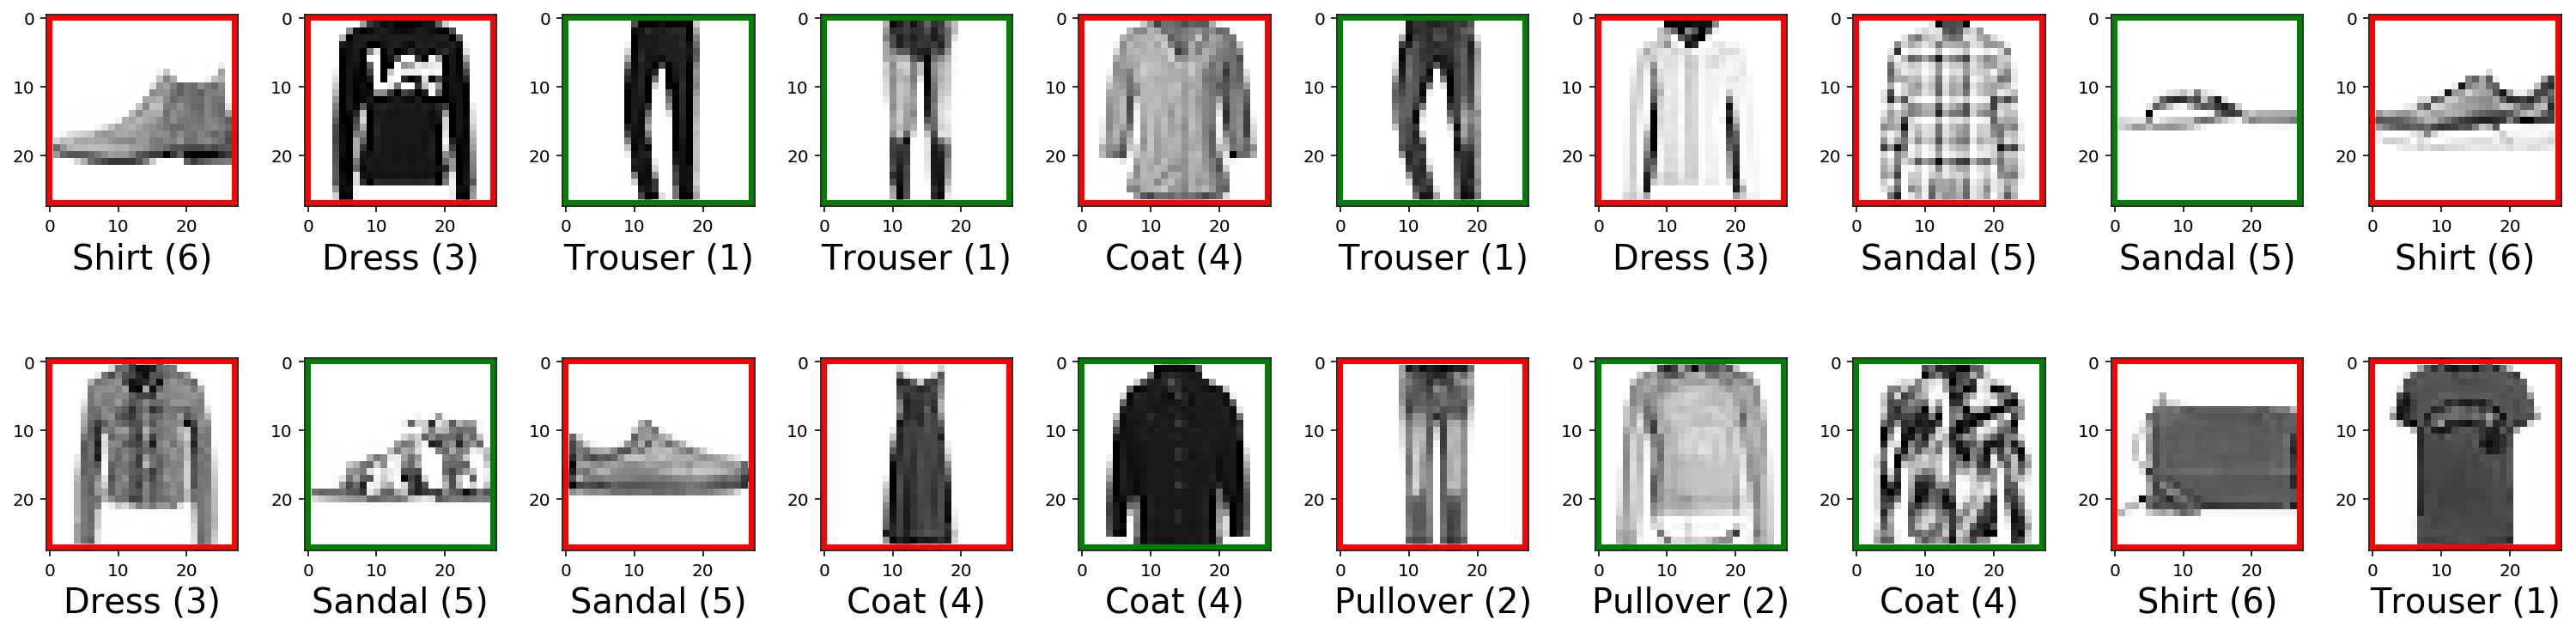

In [38]:
# solution
parameters_linear = {'W1': init_weights(50, 784),
                     'W2': init_weights(1, 50),
                     'b1': np.zeros([50]),
                     'b2': np.zeros([1]),
                     'h': identity,
                     'back_h': backprop_identity_x
                    }

accuracy_reg_shallow = train_and_evaluate(parameters_linear, num_epochs, learning_rate,
                                  fashion_train_regression, fashion_test_regression)

Great, we are better than linear regression. But how can we improve further? So far we haven't thought much about how to represent the label. 

**TODO:** Explain why the label ``7:'Sneaker'`` is so often confused with ``8:'Bag'``? Note, the class label is predicted as a scalar value and it is rounded to the next integer to query the class label by ``outputToLabel_regression``.

## Solution
Sneaker and Bag are often confused because this estimation uses linear regression and hence, the predication can easily overshoot or undershoot the estimate of the scalar value by a little bit, and it will round to other integer and result in a misclassification. Hence, we can use a classficiation algorithm to improve this process.

### 4.2 Classification (10 points)

Classification instead of regression fixes this issue. The underlying idea is to predict a probability for each class. A vector of length 10 with values between 0 and 1, where a value of 1 at position $k$ means that the class $k$ is present and zero means that the object is not of that class. I.e. a shirt should be labeled  ``[0,0,0,0,0,0,1,0,0,0]``, a one at the 6'th position (for the 6th label) and zeroes everywhere else. 
This representation allows the network to predict uncertainty, e.g.``[0,0,0,0,0,0,0.8,0,0,0.2]`` to indicate that it is 80% sure to see a shirt, which mitigates the previously enforced ordering of labels. 

We provide a function **``fashion_prepare_classification(dataset, max_iterations)``** to construct the fashion dataset with the new classification implementation.

**TODO:** Implement the inverse function **``predictionToLabel_classification(x)``** that recovers the original scalar label ``label`` from the class vector. Predicting a class will lead to inaccuracies, the predicted value will not be perfectly 0 or 1. Select the index of the class vector element with the largest value as the recovered label. The function should return an integer.

In [39]:
# solution
def predictionToLabel_classification(x):
    return np.argmax(x)

def fashion_prepare_classification(dataset, max_iterations=10000):
    images_prep = (dataset['images'][:max_iterations] - fashion_mean) / fashion_std
    labels_prep = np.zeros([max_iterations,10])
    for i in range(max_iterations):
        labels_prep[i,dataset['labels'][i]] = 1
    return {'images': images_prep,
            'labels': labels_prep}

fashion_train_classification = fashion_prepare_classification(fashion_train)
fashion_test_classification  = fashion_prepare_classification(fashion_test)

**TODO:** Define a new network and train it with the classification dataset. Name it ``parameters_classification``. Note, the output dimension of the network is no longer 1.

Finished training iteration 9900, learning rate = 0.001
Done epoch 0, accuracy = 77.9%
Finished training iteration 9900, learning rate = 0.001
Done epoch 1, accuracy = 79.24%
Finished training iteration 9900, learning rate = 0.001
Done epoch 2, accuracy = 80.36%


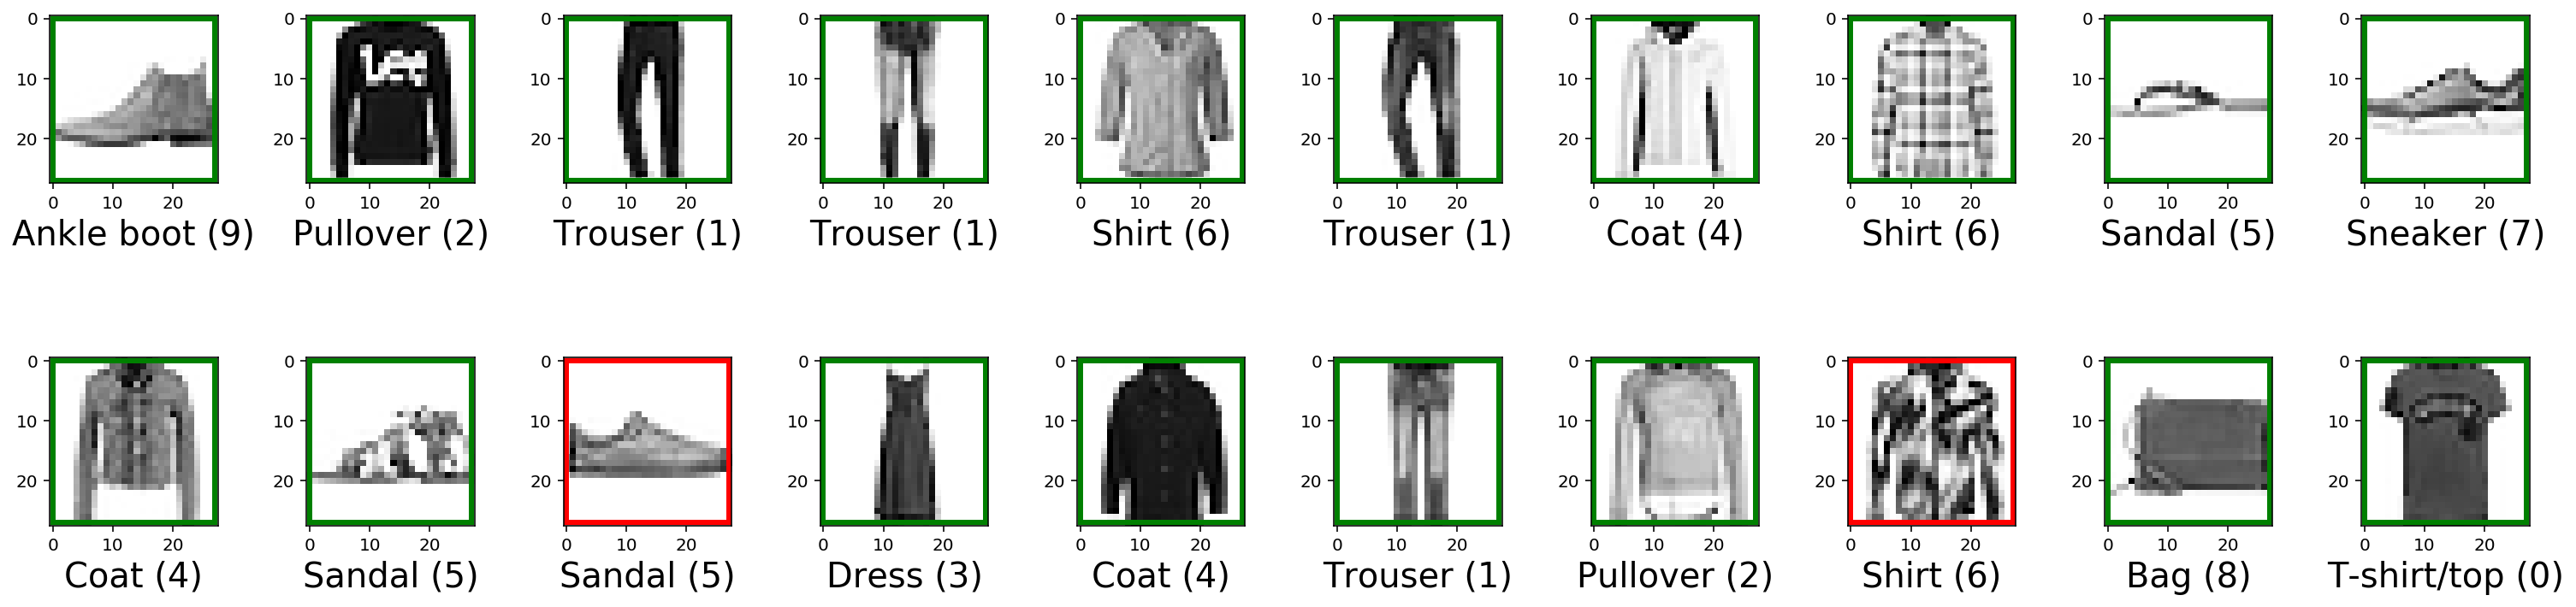

In [40]:
# solution
parameters_classification = {'W1': init_weights(50, 784),
                             'W2': init_weights(10, 50),
                             'b1': np.zeros([50]),
                             'b2': np.zeros([10]),
                             'h': relu,
                             'back_h': backprop_relu_x}

accuracy_class_shallow = train_and_evaluate(parameters_classification, num_epochs, learning_rate,
                   fashion_train_classification, fashion_test_classification,
                   outputToLabel=predictionToLabel_classification)

Well, that result looks promising, about 80% accuracy!

**TODO** Define a network with more neurons in the hidden layer that performs even better. Improvements of at least 2% are possible. Name it ``architecture_wide``. What number of neurons is a good choice?

Finished training iteration 9900, learning rate = 0.001
Done epoch 0, accuracy = 80.39%
Finished training iteration 9900, learning rate = 0.001
Done epoch 1, accuracy = 82.17%
Finished training iteration 9900, learning rate = 0.001
Done epoch 2, accuracy = 83.33%


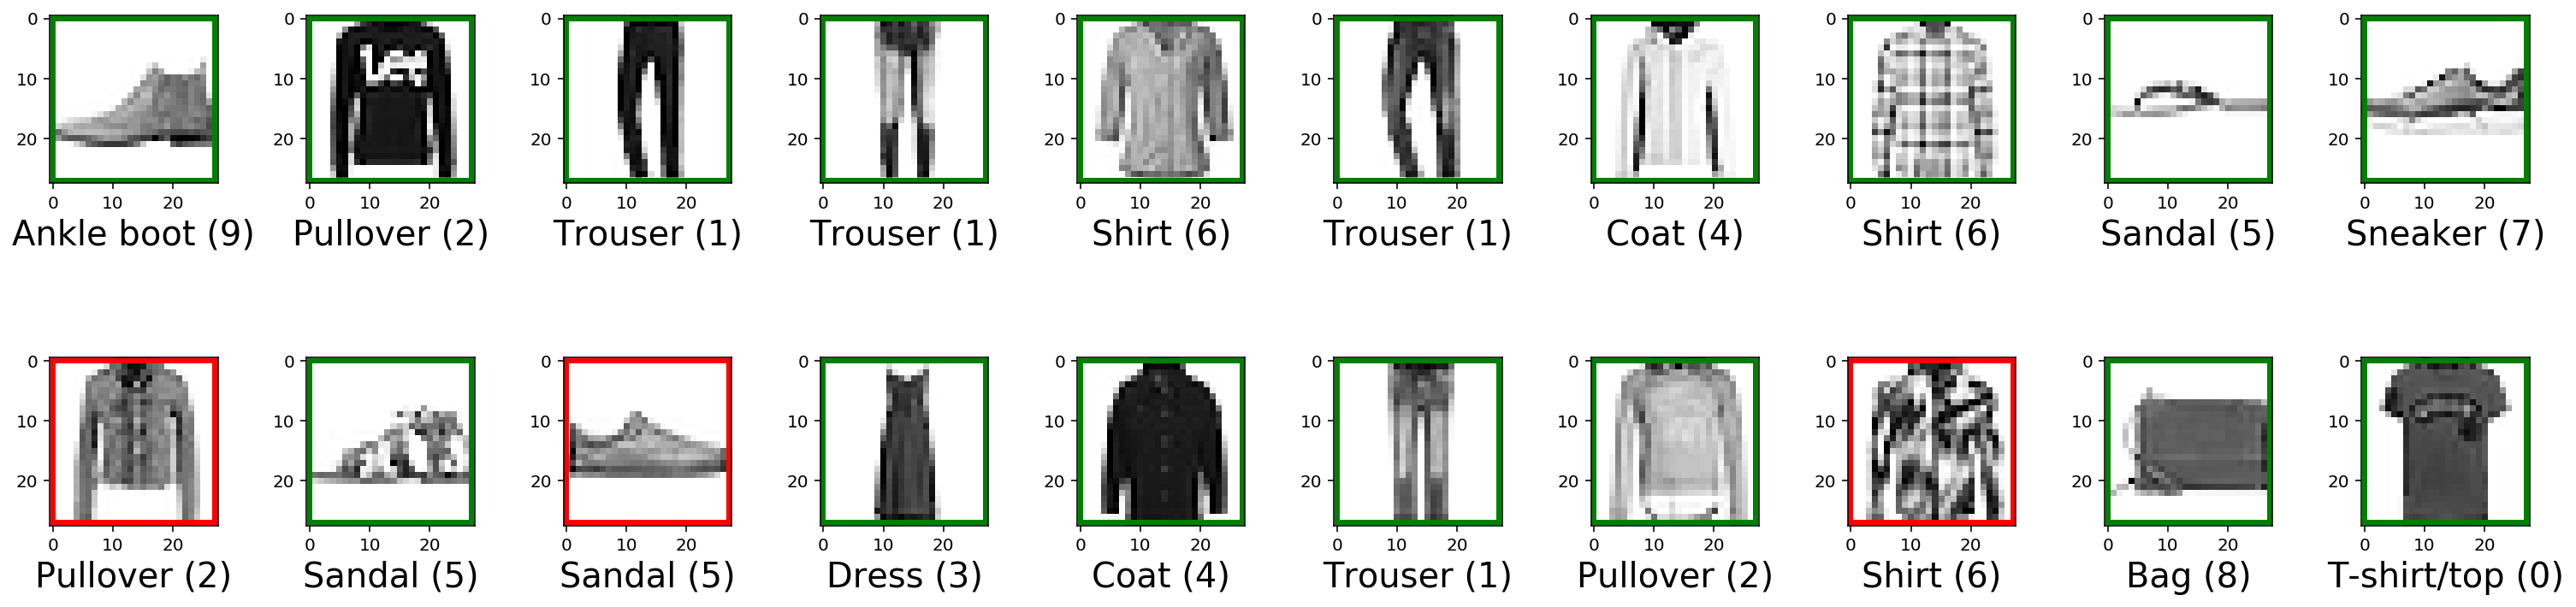

In [41]:
# solution 
architecture_wide = {'W1': init_weights(200, 784),
                         'W2': init_weights(10, 200),
                         'b1': np.zeros([200]),
                         'b2': np.zeros([10]),
                         'h': relu,
                         'back_h': backprop_relu_x}

accuracy_class_wide = train_and_evaluate(architecture_wide, num_epochs, learning_rate,
                   fashion_train_classification, fashion_test_classification,
                   outputToLabel=predictionToLabel_classification)

There is a tradeoff between number of neurons and speed. More neurons often result in more accuracy, but also takes a longer time to run. In this case, 200 neurons produce an accuracy of 83.33% which is pretty good.

<div class="alert alert-block alert-info">
**Important:** Please submit only the Jupyter notebook file, not the dataset and embedded pictures. Submit a notebook that contains your final output cells. That means, run 'Kernel' -> 'Restart & Run All', save, and submit the outcome.
</div>